In [16]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
RES_DIR1 = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds"

## default
#RES_DIR = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results4"

RES_DIRS = []
RES_DIRS.append(RES_DIR1)
#RES_DIRS.append(RES_DIR2)
#RES_DIRS.append(RES_DIR3)

assert os.path.exists(RES_DIR1)

SAVE_DIR ="./figures/results2/"
make_dir(SAVE_DIR)
FN_TMP = "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}.png"

COLORS = {}
COLORS["Flow Loss"] = "blue"
COLORS["Flow Loss Bitmap"] = "lightblue"

COLORS["Q-Error"] = "green"
COLORS["Q-Error Bitmap"] = "lightgreen"

LINESTYLES = {}
LINESTYLES["Flow Loss"] = ":"
LINESTYLES["Q-Error"] = "--"
LINESTYLES["Flow Loss Bitmap"] =  ":"
LINESTYLES["Q-Error Bitmap"] = "--"

# LINESTYLES["Flow Loss Bitmap"] =  (0, (3, 10, 1, 10))
# LINESTYLES["Q-Error Bitmap"] = (0, (3, 10, 1, 10))

ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Flow Loss"
ALG_KEY["flow_loss2_bitmap"] = "Flow Loss Bitmap"

ALG_KEY["mse"] = "Q-Error"
ALG_KEY["mse_bitmap"] = "Q-Error Bitmap"

OVERLAP_INFO = "./all_results/3/overlap_info.pkl"

dfs = []
for res_dir in RES_DIRS:
    df = get_summary_df(res_dir)
    if "final_results2" in res_dir:
        df = df[df.feat_rel_pg_ests_onehot == 1]
    df["res_dir"] = str(deterministic_hash(res_dir))[0:5]
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

7
diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:flow_loss2-0.0--D0.1-637
******
skipping  /home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds/diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:flow_loss2-0.0--D0.1-920
skipping  /home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds/diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:mse-0.0--D0.1-808
skipping  /home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds/diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:flow_loss2-0.0--D0.1-142
6
diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:flow_loss2-0.0--D0.1-505
******
6
diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:mse-0.0--D0.1-725
******
7
diff_partitions-nested_loop_index7-mscn-df:10-nn:2:512-loss:mse-0.0--D0.1-102
******
skipping 

In [7]:
df = df[df["alg_name"] != "true"]
df = df[df["alg_name"] != "postgres"]
df = df[df["weight_decay"] == 0.1]

all_df = df[df["template"] != "all"]
df = df[df["template"] == "all"]
df = df[df["summary_type"] == "mean"]

print("additional default filters")
df = df[df.test_size == 0.5]
df = df[df.max_discrete_featurizing_buckets == 10]

print(set(df["alg_name"]))
print(set(df["flow_features"]))
print(set(df["sample_bitmap"]))
print(set(df["feat_rel_pg_ests_onehot"]))
print(set(df["hidden_layer_size"]))
print(set(df["test_size"]))
print(set(df["weight_decay"]))




additional default filters
{'mse', 'flow_loss2'}
{1}
{0}
{1}
{512}
{0.5}
{0.1}


In [44]:
def get_part_losses(df, key):
    losses = []
    for part in set(df["partition"]):
        tmp = df[df.partition == part]
        if len(tmp) == 0:
            continue
        losses.append(np.mean(tmp[key].values))
    
    return np.array(losses)
        
def plot_bar_chart(df, err_type, st, yscale="linear", key="loss", ylabel="", ymax=None, err_bar="percentiles"):
    df = df[df.samples_type == st]
    fn = FN_TMP.format(ERROR_TYPE = err_type,
                       SAMPLES_TYPE = st,
                       PART = "All-Bar-" + err_bar)
    fn = SAVE_DIR + fn

    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')

    plt.title(err_type)
    

    algs = ["flow_loss2", "mse"]
    for alg in algs:
        if alg == "true" and key != "runtime":
            continue

        tmp_df = df[df.alg_name == alg]
        alg_label = ALG_KEY[alg]
        
        losses = get_part_losses(tmp_df, key)
        
        std = np.std(losses)
        count = len(losses)
        mean = np.mean(losses)
        median = np.median(losses)
        p90 = np.percentile(losses, 95)
        p10 = np.percentile(losses, 5)

        
        if err_bar == "percentiles":
            plt.bar(alg_label, height=mean, yerr=[[p10], [p90]],label = alg_label, linestyle="--", linewidth=3, 
                    color = COLORS[alg_label], capsize=10)
        elif err_bar == "std":                         
            plt.bar(alg_label, height=mean, yerr=std,label = alg_label, linestyle="--", linewidth=3, 
                color = COLORS[alg_label], capsize=10)
    
    
    plt.ylabel(ylabel)
    plt.xlabel("Loss Function")
    plt.yscale(yscale)
    plt.legend(frameon=False, loc="upper left")
    plt.savefig(fn)
    plt.show()

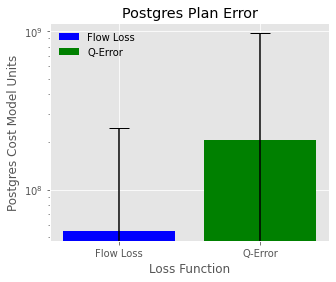

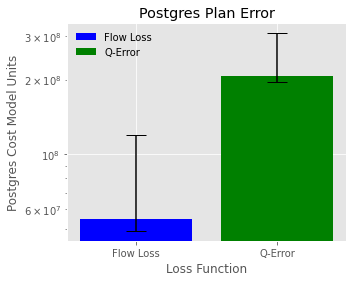

In [45]:
jerrs = df[df.loss_type == "jerr"]
plot_bar_chart(jerrs, "Postgres Plan Error", "test", yscale="log", ylabel="Postgres Cost Model Units", err_bar="std")
plot_bar_chart(jerrs, "Postgres Plan Error", "test", yscale="log", ylabel="Postgres Cost Model Units", 
               err_bar="percentiles")

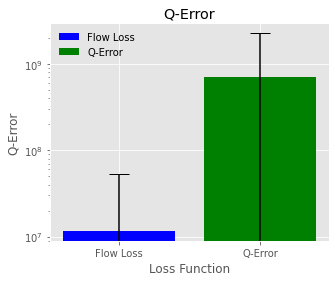

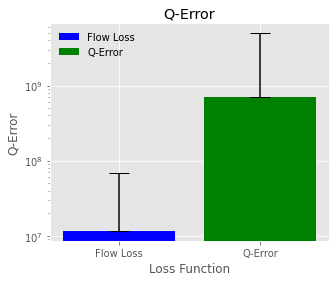

In [47]:
qerrs = df[df.loss_type == "qerr"]
plot_bar_chart(qerrs, "Q-Error", "test", yscale="log", ylabel="Q-Error", err_bar="std")
plot_bar_chart(qerrs, "Q-Error", "test", yscale="log", ylabel="Q-Error", 
               err_bar="percentiles")

In [39]:
set(jerrs["alg_name"])

{'flow_loss2', 'mse'}